<a href="https://colab.research.google.com/github/alex-loo/electricty_market/blob/main/USEP_charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly import subplots
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

In [39]:
!pip install -- update plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
pd.options.display.float_format = '{:,.2f}'.format

In [41]:
#Creating tick locators

year_locator = mdates.YearLocator()
month_locator = mdates.MonthLocator()
year_fmt = mdates.DateFormatter('%Y')

In [42]:
path = "/content/drive/MyDrive/Python/AAR/Data Analysis/data/USEP"
file_list = os.listdir(path)
df_append = pd.read_csv(f"{path}/USEP_Jan-2011.csv")

for file in file_list:
  if file == 'USEP_Jan-2011.csv':
    pass
  else:
    temp_df = pd.read_csv(f"{path}/{file}")
    df_append = df_append.append(temp_df)

In [43]:
print(f"There are {df_append.shape[0]} rows and {df_append.shape[1]} columns.")

There are 208272 rows and 9 columns.


In [44]:
df_append.dtypes

PRICE TYPE           object
DATE                 object
PERIOD                int64
PRICE ($/MWh)       float64
DEMAND (MW)         float64
INFORMATION TYPE     object
USEP ($/MWh)        float64
LCP ($/MWh)         float64
TCL (MW)            float64
dtype: object

In [45]:
# Dealing with Null values and different column names
df_append.fillna(0, inplace=True)
df_append['USEP ($/MWh)'] += df_append['PRICE ($/MWh)']
df_append = df_append[['DATE', 'PERIOD', 'USEP ($/MWh)']]

In [46]:
df_append.tail()

,DATE,PERIOD,USEP ($/MWh)
1435,30 Apr 2020,44,46.99
1436,30 Apr 2020,45,43.44
1437,30 Apr 2020,46,42.70
1438,30 Apr 2020,47,41.39
1439,30 Apr 2020,48,41.39


In [47]:
# Creating datetime objects and sorting the data chronologically
df_append.DATE = pd.to_datetime(df_append.DATE)
df_append.sort_values(by=['DATE', 'PERIOD'], ascending=True, inplace=True)

In [48]:
# Change from $/MWh to cents/kWh
df_append['USEP(¢/kWh)'] = df_append['USEP ($/MWh)'] / 10
df_append.drop(columns=['USEP ($/MWh)'], inplace=True)

In [49]:
# Layering in SP LT Tariff rates, which resets at the start of every quarter
df_lt = pd.read_csv(
    "/content/drive/MyDrive/Python/AAR/Data Analysis/data/SP/SP_LT_tariff.csv", 
    encoding='unicode_escape')
df_lt.DATE = pd.to_datetime(df_lt.DATE, format='%d/%m/%Y')

df_merged = pd.merge(df_append, df_lt, how='left', on='DATE')

In [50]:
# Filling the Null values (on dates that are not start of quarter)
df_merged = df_merged.fillna(method='ffill')

In [51]:
# Resample the data to daily and monthly frequency
daily_avg = df_merged.resample('D', on='DATE').mean().rename(
            columns={'USEP(¢/kWh)':'USEP_avg(¢/kWh)'}).drop(
            columns='PERIOD')
monthly_avg = df_merged.resample('M', on='DATE').mean().rename(
              columns={'USEP(¢/kWh)':'USEP_avg(¢/kWh)'}).drop(
              columns='PERIOD')
quarterly_avg = df_merged.resample('Q', on='DATE').mean().rename(
              columns={'USEP(¢/kWh)':'USEP_avg(¢/kWh)'}).drop(
              columns='PERIOD')

In [52]:
# Do the same for daytime averages
df_daytime = df_merged.query('15 <= PERIOD <= 36')
daytime_d = df_daytime.resample('D', on='DATE').mean().rename(
              columns={'USEP(¢/kWh)':'USEP_dt(¢/kWh)'})
daytime_m = df_daytime.resample('M', on='DATE').mean().rename(
              columns={'USEP(¢/kWh)':'USEP_dt(¢/kWh)'})
daytime_q = df_daytime.resample('Q', on='DATE').mean().rename(
              columns={'USEP(¢/kWh)':'USEP_dt(¢/kWh)'})

In [53]:
# Inserting the daytime average column
daily_avg.insert(loc=2,column='USEP_dt(¢/kWh)', value=daytime_d['USEP_dt(¢/kWh)'])
monthly_avg.insert(loc=2,column='USEP_dt(¢/kWh)', value=daytime_m['USEP_dt(¢/kWh)'])

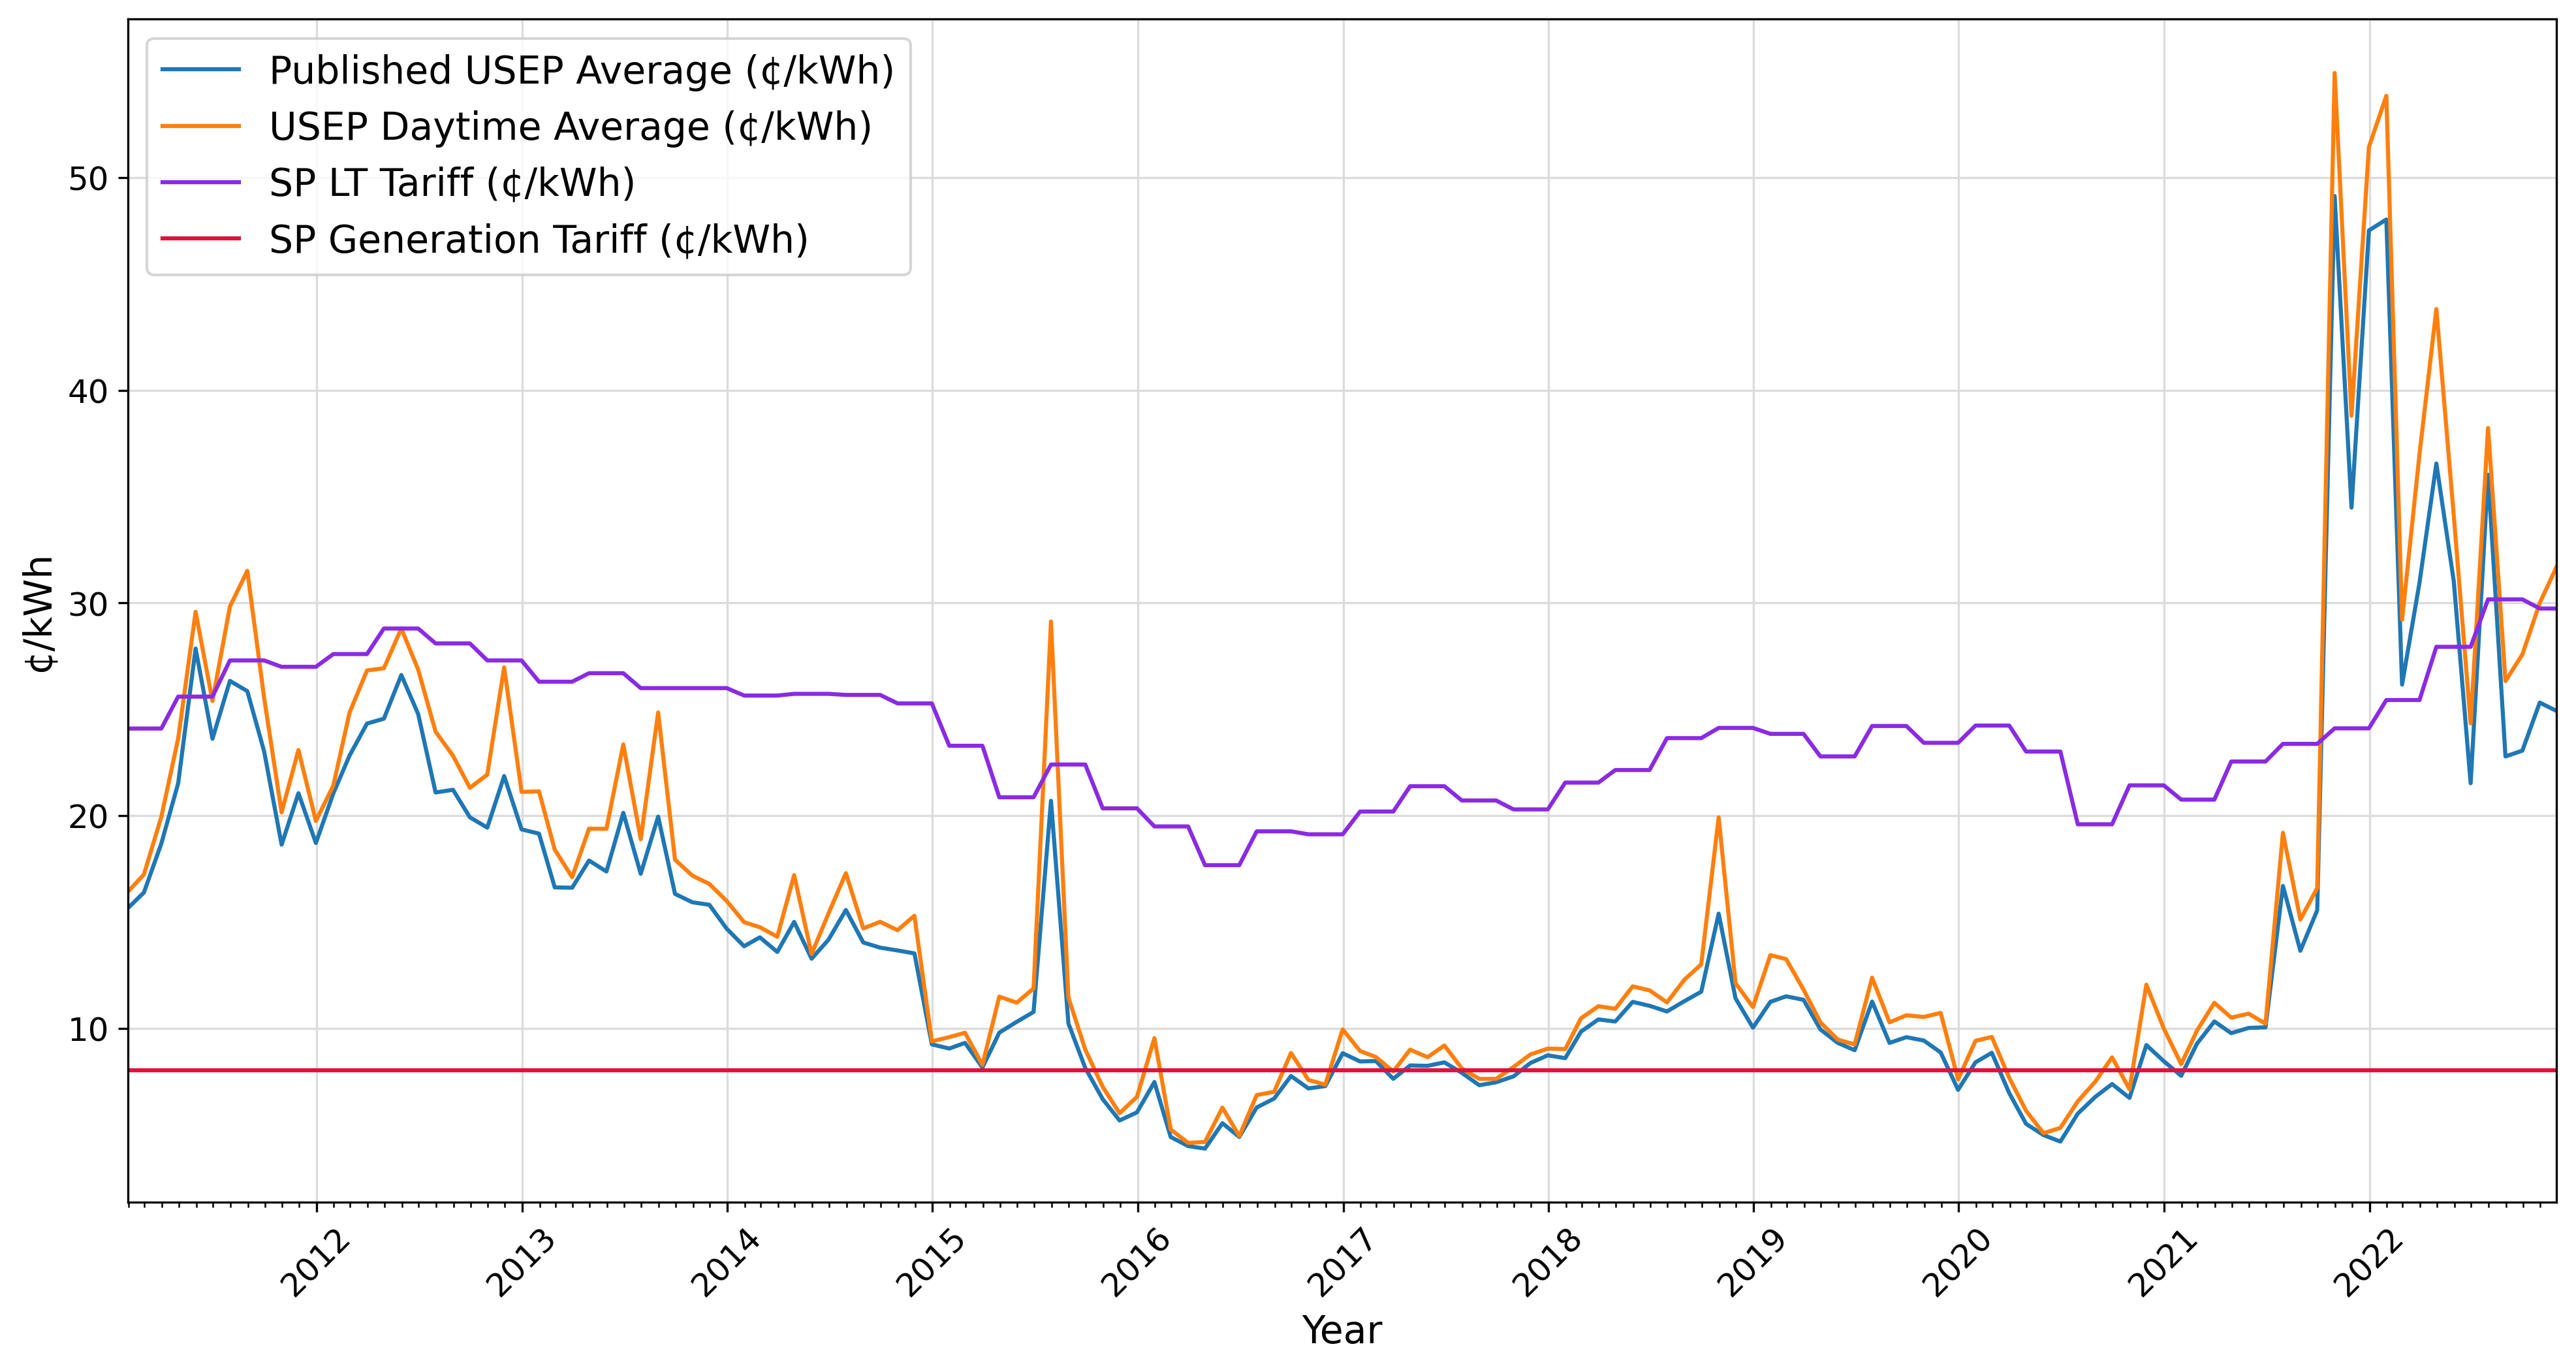

In [54]:
# Plotting the different electricity rates on a single chart
year_start = '2011-01-01'
plt.figure(figsize=(16,8), dpi=300)

ax = plt.gca()

line_usep = plt.plot(monthly_avg.index,
                     monthly_avg['USEP_avg(¢/kWh)'],
                     label='Published USEP Average (¢/kWh)')
line_dt = plt.plot(monthly_avg.index,
                   monthly_avg['USEP_dt(¢/kWh)'],
                   label='USEP Daytime Average (¢/kWh)')

line_sp = plt.plot(monthly_avg.index,
                   monthly_avg['SP_LT_TARIFF(¢/kWh)'],
                   label='SP LT Tariff (¢/kWh)',
                   color='blueviolet')

plt.axhline(y=8.055, color='crimson', label='SP Generation Tariff (¢/kWh)')

plt.grid(color='gainsboro')

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.xlim((monthly_avg.index.min(), monthly_avg.index.max()))

ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_minor_locator(month_locator)
ax.xaxis.set_major_formatter(year_fmt)

plt.ylabel('¢/kWh', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend(loc='upper left', fontsize=14)

plt.savefig("/content/drive/MyDrive/Python/AAR/Data Analysis/output/charts/usep_hist.png")

In [55]:
# Reading solar generation income csv file

df_green = pd.read_csv('/content/drive/MyDrive/Python/AAR/Data Analysis/data/green_income.csv')

# Creating datetime objects
df_green.Date = pd.to_datetime(df_green.Date, format='%d/%m/%Y')

df_green = df_green[df_green.Date <= '2022-10-31']

In [56]:
bar = px.bar(df_green,
             x='Date',
             y='Net_Income',
             color='Net_Income',
             color_continuous_scale='haline',
             template='seaborn',
             title="Net Income from Solar Generation (Jan '11 - Oct '22)")

bar.update_xaxes(nticks=12)
bar.update_traces(hovertemplate='Month: %{x} <br>Net Income: $%{y:,.0f}')
bar.update_layout(xaxis_title='Year', yaxis_title="Net Income ($)",
                  coloraxis_showscale=False)

bar.write_html("/content/drive/MyDrive/Python/AAR/Data Analysis/output/charts/net_income.html")
bar.show()

In [57]:
fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])
monthly_trun = monthly_avg[monthly_avg.index <= '2022-10-31']
fig.add_trace(
    go.Scatter(
        x=monthly_trun.index,
        y=monthly_trun['USEP_avg(¢/kWh)'],
        name='USEP Average (¢/kWh)'),
        secondary_y=True)

fig.add_trace(
    go.Bar(
        x=df_green.Date,
        y=df_green.Net_Income,
        name="Solar Income (S$)"
    ))


fig.update_layout(title="Net Income from Solar Generation (Jan '11 - Oct '22)",
                  template='seaborn', xaxis_title='Year', 
                  yaxis_title="Net Income from Solar Generation, (S$)", 
                  width=1800, height=900)
fig.update_xaxes(nticks=12)
fig.update_yaxes(title='USEP Average (¢/kWh)', secondary_y=True)

fig.show()
fig.write_html('/content/drive/MyDrive/Python/AAR/Data Analysis/output/charts/combined.html')

In [58]:
# Saving the output data in an Excel
daily_avg.index = daily_avg.index.date
monthly_avg.index = monthly_avg.index.date

df_merged.to_csv("/content/drive/MyDrive/Python/AAR/Data Analysis/output/output data/usep_raw.csv")
quarterly_avg.to_csv("/content/drive/MyDrive/Python/AAR/Data Analysis/output/output data/usep_q.csv")

with pd.ExcelWriter("/content/drive/MyDrive/Python/AAR/Data Analysis/output/output data/data_merged.xlsx") as writer:
  daily_avg.to_excel(writer, sheet_name='daily')
  monthly_avg.to_excel(writer, sheet_name='monthly')